In [1]:
import os
import re
import sys

import pandas
import yaml

################################################################################
# Boilerplate
################################################################################

# ANSI SGR control codes for text formatting
class Text:
    DEFAULT = "\x1b[0m"
    BOLD = "\x1b[1m"
    BOLD_OFF = "\x1b[22m"
    UNDERLINE = "\x1b[4m"
    UNDERLINE_OFF = "\x1b[24m"
    DEFAULT_COLOR = "\x1b[39m"
    DEFAULT_BG_COLOR = "\x1b[49m"
    RED = "\x1b[31m"
    YELLOW = "\x1b[33m"
    GREEN = "\x1b[32m"
    CYAN = "\x1b[36m"
    BLUE = "\x1b[34m"
    MAGENTA = "\x1b[35m"
    BLACK = "\x1b[30m"
    WHITE = "\x1b[37m"
    BG_RED = "\x1b[41m"
    BG_YELLOW = "\x1b[43m"
    BG_GREEN = "\x1b[42m"
    BG_CYAN = "\x1b[46m"
    BG_BLUE = "\x1b[44m"
    BG_MAGENTA = "\x1b[45m"
    BG_BLACK = "\x1b[40m"
    BG_WHITE = "\x1b[47m"


def warn(mesg: str) -> None:
    sys.stderr.write(f'{Text.YELLOW}{mesg}\n{Text.DEFAULT}')


def error(mesg: str, err_code: int = 1) -> None:
    sys.stderr.write(f'{Text.RED}{mesg}\n{Text.DEFAULT}')
    sys.exit(err_code)


def import_yaml(file_path: str) -> dict[any, any]:
    with open(file_path, 'r', encoding='UTF-8') as file:
        data = yaml.safe_load(file)
    return data


def get_results_files(run_dir: str) -> list[str]:
    """
    Get list of results files from run.

    If a particular workload has multiple results files, pick newest based on
    filename's date.
    """
    results_files = []
    if not os.path.isdir(run_dir):
        warn(f'Invalid run directory: {run_dir}')
        return results_files
    if not os.path.isdir(os.path.join(run_dir, 'results')):
        warn(f'"results" directory missing in run: {run_dir}')
        return results_files
    # Within the results directory of a run, there can be several benchmarks
    for benchmark in os.listdir(os.path.join(run_dir, 'results')):
        if not os.path.isdir(os.path.join(run_dir, 'results', benchmark)):
            continue
        # Sort files by newest first
        files_sorted = sorted(
            os.listdir(os.path.join(run_dir, 'results', benchmark)),
            # Sorting by modified time will not work if files are copied
            # locally in arbitrary order
            #key=lambda ff: os.path.getmtime(os.path.join(run_dir, "results", benchmark, ff)),
            reverse=True)
        for file in files_sorted:
            if not os.path.isfile(os.path.join(run_dir, 'results', benchmark, file)):
                continue
            if not re.search('^vllm.+\.json$', file):
                # Skip files that do not match result data filename
                continue
            results_files.append(os.path.join(run_dir, 'results', benchmark, file))
            break
    return results_files


def get_workload_profile(run_dir: str) -> dict[str, any]:
    """Get workload profile file from run."""
    if not os.path.isdir(run_dir):
        error(f'Invalid run directory: {run_dir}')
    if not os.path.isdir(os.path.join(run_dir, 'workload')):
        error(f'"workload" directory missing in run: {run_dir}')
    if not os.path.isdir(os.path.join(run_dir, 'workload', 'profiles')):
        error(f'"workload/profiles" directory missing in run: {run_dir}')
    # Get the workload file (there should be only one, and we will assume this)
    for file in os.listdir(os.path.join(run_dir, 'workload', 'profiles')):
        if os.path.isdir(os.path.join(run_dir, 'workload', 'profiles', file)):
            continue
        if not re.search('.+\.yaml$', file):
            # Skip files that do not match result data filename
            continue
        return import_yaml(os.path.join(run_dir, 'workload', 'profiles', file))


def get_envar(run_dir: str, envar: str) -> str:
    """Get value of environment variable in environment/variables file of run."""
    if not os.path.isdir(run_dir):
        error(f'Invalid run directory: {run_dir}')
    if not os.path.isdir(os.path.join(run_dir, "environment")):
        error(f'"environment" directory missing in run: {run_dir}')
    if not os.path.isfile(os.path.join(run_dir, "environment", "variables")):
        error(f'"variables" file missing in run: {os.path.join(run_dir, "environment")}')
    with open(os.path.join(run_dir, "environment", "variables"), "r", encoding="UTF-8") as file:
        for line in file:
            if envar in line:
                model = line.rsplit('=', 1)[-1].strip()
                if not model:
                    error(f'{envar} not defined: {run_dir}')
                return model
        error(f'{envar} missing from environment/variables: {run_dir}')

################################################################################
# Import data
################################################################################

# This is the directory containing run directories to import
source_dir = "./"

if not os.path.isdir(source_dir):
    sys.stderr.write(f'{Text.RED}Invalid path: {source_dir}\n{Text.DEFAULT}')
    sys.exit(1)

# Make a list of experimental directories
run_dirs = []
for file in os.listdir(source_dir):
    if not os.path.isdir(file):
        # Skip files that are not directories
        continue
    if not re.search('.+\_\_[0-9]+R-TP[0-9]+$', file):
        # Skip directories that do not match a swept run pattern
        continue
    run_dirs.append(file)

if not run_dirs:
    sys.stderr.write(f'{Text.RED}No run directories found in source directory: {source_dir}\n{Text.DEFAULT}')
    sys.exit(1)

run_dirs.sort()

# Set of configurations we have data from, in the format (tp, rep)
configs = set([])

# Create DataFrame for benchmark run results
runs = pandas.DataFrame(columns=[
    'Name',
    'Model',
    'GPU',
    'TP',
    'Replicas',
    'Concurrency',
    'ISL',
    'OSL',
    'Request_Throughput',
    'Output_Throughput',
    'Total_Token_Throughput',
    'Total_Input_Tokens',
    'Total_Output_Tokens',
    'Completed',
    'Mean_TTFT',
    'Std_TTFT',
    'Mean_TPOT',
    'Std_TPOT',
    'Mean_ITL',
    'Std_ITL',
    'Mean_E2E',
    'Std_E2E',
])

# Import data and populate DataFrame
for run in run_dirs:
    results_files = get_results_files(os.path.join(source_dir, run))
    model = get_envar(os.path.join(source_dir, run), 'LLMDBENCH_DEPLOY_MODEL_LIST')
    gpu = get_envar(os.path.join(source_dir, run), 'LLMDBENCH_VLLM_COMMON_AFFINITY').rsplit(':', 1)[-1]
    name, config_str = run.rsplit('__', 1)
    rep = int(config_str.split('R-TP', 1)[0])
    tp = int(config_str.split('R-TP', 1)[-1])
    configs.add((tp, rep))
    workload_profile = get_workload_profile(run)
    for rf in results_files:
        result_data = import_yaml(rf)
        runs.loc[len(runs)] = {
            'Name': name,
            'Model': model,
            'GPU': gpu,
            'TP': tp,
            'Replicas': rep,
            'Concurrency': result_data['max_concurrency'],
            'ISL': workload_profile['random-input-len'],
            'OSL': workload_profile['random-output-len'],
            'Request_Throughput': result_data['request_throughput'],
            'Output_Throughput': result_data['output_throughput'],
            'Total_Token_Throughput': result_data['total_token_throughput'],
            'Total_Input_Tokens': result_data['total_input_tokens'],
            'Total_Output_Tokens': result_data['total_output_tokens'],
            'Completed': result_data['completed'],
            'Mean_TTFT': result_data['mean_ttft_ms'],
            'Std_TTFT': result_data['std_ttft_ms'],
            'Mean_TPOT': result_data['mean_tpot_ms'],
            'Std_TPOT': result_data['std_tpot_ms'],
            'Mean_ITL': result_data['mean_itl_ms'],
            'Std_ITL': result_data['std_itl_ms'],
            'Mean_E2E': result_data['mean_e2el_ms'],
            'Std_E2E': result_data['std_e2el_ms'],
        }

# Preview data
runs

,Name,Model,GPU,TP,Replicas,Concurrency,ISL,OSL,Request_Throughput,Output_Throughput,...,Total_Output_Tokens,Completed,Mean_TTFT,Std_TTFT,Mean_TPOT,Std_TPOT,Mean_ITL,Std_ITL,Mean_E2E,Std_E2E
0,benchmark_run_sa,Qwen/Qwen1.5-MoE-A2.7B-Chat,NVIDIA-H100-80GB-HBM3,1,16,8,10000,1000,1.361336,1361.336119,...,160000,160,248.013182,134.800241,5.514725,0.676372,5.515312,4.930411,5757.223598,734.004246
1,benchmark_run_sa,Qwen/Qwen1.5-MoE-A2.7B-Chat,NVIDIA-H100-80GB-HBM3,1,16,1,10000,1000,0.191415,191.415159,...,20000,20,233.290650,25.183322,4.995555,0.023793,4.995555,0.175206,5223.850033,32.529446
2,benchmark_run_sa,Qwen/Qwen1.5-MoE-A2.7B-Chat,NVIDIA-H100-80GB-HBM3,1,16,512,10000,1000,12.429467,12429.467062,...,10240000,10240,11966.884331,14627.775184,27.115250,4.063493,27.115404,89.570000,39055.019213,15905.209875
3,benchmark_run_sa,Qwen/Qwen1.5-MoE-A2.7B-Chat,NVIDIA-H100-80GB-HBM3,1,16,128,10000,1000,8.400128,8400.128236,...,2560000,2560,280.615853,226.048599,14.676530,4.236254,14.676920,12.174766,14942.468932,4268.308768
4,benchmark_run_sa,Qwen/Qwen1.5-MoE-A2.7B-Chat,NVIDIA-H100-80GB-HBM3,1,16,64,10000,1000,6.026955,6026.954837,...,1280000,1280,244.857575,122.825985,10.112926,2.751224,10.113963,8.631156,10347.671108,2764.434966
5,benchmark_run_sa,Qwen/Qwen1.5-MoE-A2.7B-Chat,NVIDIA-H100-80GB-HBM3,8,2,8,10000,1000,1.706818,1706.818204,...,160000,160,120.115273,95.214741,4.502071,0.332428,4.503198,4.100531,4617.684552,344.605462
6,benchmark_run_sa,Qwen/Qwen1.5-MoE-A2.7B-Chat,NVIDIA-H100-80GB-HBM3,8,2,512,10000,1000,11.882503,11882.502530,...,10240000,10240,1223.241740,2404.314936,41.501937,4.171566,41.501941,27.613013,42683.676325,5065.368319
7,benchmark_run_sa,Qwen/Qwen1.5-MoE-A2.7B-Chat,NVIDIA-H100-80GB-HBM3,8,2,128,10000,1000,8.457734,8457.733544,...,2560000,2560,229.338220,434.079731,14.725673,2.156916,14.727614,11.772316,14940.285608,2225.824099
8,benchmark_run_sa,Qwen/Qwen1.5-MoE-A2.7B-Chat,NVIDIA-H100-80GB-HBM3,8,2,64,10000,1000,6.623482,6623.482137,...,1280000,1280,167.826742,231.091531,9.365894,0.850561,9.369521,7.920142,9524.354655,887.884020
9,benchmark_run_sa,Qwen/Qwen1.5-MoE-A2.7B-Chat,NVIDIA-H100-80GB-HBM3,8,2,1,10000,1000,0.264016,264.015822,...,20000,20,100.733553,22.779684,3.690184,0.061160,3.690554,1.965937,3787.227271,68.133332


In [2]:
runs.columns

Index(['Name', 'Model', 'GPU', 'TP', 'Replicas', 'Concurrency', 'ISL', 'OSL',
       'Request_Throughput', 'Output_Throughput', 'Total_Token_Throughput',
       'Total_Input_Tokens', 'Total_Output_Tokens', 'Completed', 'Mean_TTFT',
       'Std_TTFT', 'Mean_TPOT', 'Std_TPOT', 'Mean_ITL', 'Std_ITL', 'Mean_E2E',
       'Std_E2E'],
      dtype='object')

In [4]:
# Filters
isl = 10000
osl = 1000
model = 'Qwen/Qwen1.5-MoE-A2.7B-Chat'

# Filter on column values, then pick specific columns from dataset to analyze
runs_selected = runs[
    (runs['ISL'] == isl) &
    (runs['OSL'] == osl) &
    (runs['Model'] == model)][[
    'Model',
    'TP',
    'Replicas',
    'Concurrency',
    'ISL',
    'OSL',
    'Output_Throughput']].drop('Model', axis=1).drop('ISL', axis=1).drop('OSL', axis=1).sort_values(by='Output_Throughput')
# Add calculated columns
runs_selected['Num_GPUs'] = runs_selected['TP']*runs_selected['Replicas']
runs_selected['Thpt_per_GPU'] = runs_selected['Output_Throughput']/runs_selected['Num_GPUs']
runs_selected['Thpt_per_User'] = runs_selected['Output_Throughput']/runs_selected['Concurrency']
# Preview
runs_selected

,TP,Replicas,Concurrency,Output_Throughput,Num_GPUs,Thpt_per_GPU,Thpt_per_User
1,1,16,1,191.415159,16,11.963447,191.415159
14,4,4,1,249.598289,16,15.599893,249.598289
9,8,2,1,264.015822,16,16.500989,264.015822
0,1,16,8,1361.336119,16,85.083507,170.167015
12,4,4,8,1679.650435,16,104.978152,209.956304
5,8,2,8,1706.818204,16,106.676138,213.352276
4,1,16,64,6026.954837,16,376.684677,94.171169
8,8,2,64,6623.482137,16,413.967634,103.491908
13,4,4,64,6809.541282,16,425.596330,106.399083
3,1,16,128,8400.128236,16,525.008015,65.626002


In [9]:
# See what configurations we have data on
# Format is (tp, rep)
configs

{(1, 16), (4, 4), (8, 2)}

,TP,Replicas,Concurrency,Output_Throughput,Num_GPUs,Thpt_per_GPU,Thpt_per_User
1,1,16,1,191.415159,16,11.963447,191.415159
0,1,16,8,1361.336119,16,85.083507,170.167015
4,1,16,64,6026.954837,16,376.684677,94.171169
3,1,16,128,8400.128236,16,525.008015,65.626002
2,1,16,512,12429.467062,16,776.841691,24.276303


,TP,Replicas,Concurrency,Output_Throughput,Num_GPUs,Thpt_per_GPU,Thpt_per_User
14,4,4,1,249.598289,16,15.599893,249.598289
12,4,4,8,1679.650435,16,104.978152,209.956304
13,4,4,64,6809.541282,16,425.596330,106.399083
11,4,4,128,9359.032584,16,584.939537,73.117442
10,4,4,512,13384.129788,16,836.508112,26.140878


,TP,Replicas,Concurrency,Output_Throughput,Num_GPUs,Thpt_per_GPU,Thpt_per_User
9,8,2,1,264.015822,16,16.500989,264.015822
5,8,2,8,1706.818204,16,106.676138,213.352276
8,8,2,64,6623.482137,16,413.967634,103.491908
7,8,2,128,8457.733544,16,528.608347,66.076043
6,8,2,512,11882.502530,16,742.656408,23.208013


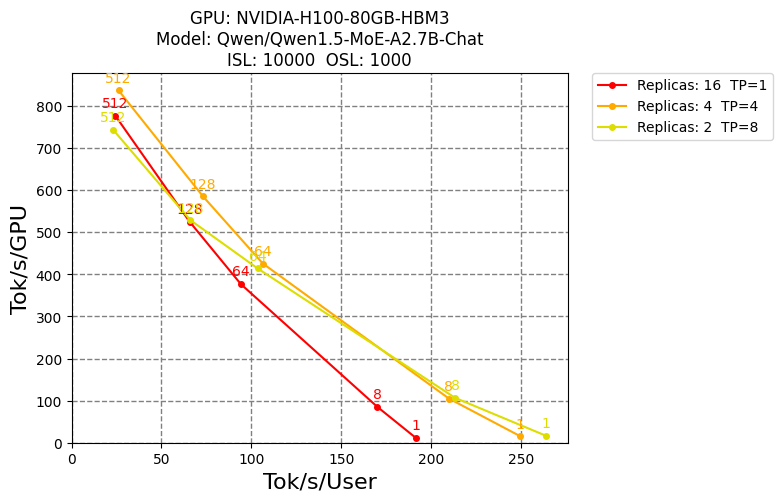

In [17]:
# Plot performance results
import matplotlib
import matplotlib.pyplot as plt

colors = ['#FF0000', '#FFAA00', '#DDDD00', '#00DD00', '#00FFFF', '#0000FF',
          '#FF00FF', '#666666', '#000000']

# Sort configurations
config_list = list(configs)
config_list.sort()
# Sweep through configurations
for ii, conf in enumerate(config_list):
    # Make a DataFrame for specific configuration
    conf_df = runs_selected[
        (runs_selected['TP'] == conf[0]) &
        (runs_selected['Replicas'] == conf[1])
    ].sort_values(by='Concurrency')
    display(conf_df)

    # Plot throughputs for configuration
    plt.plot(conf_df.Thpt_per_User, conf_df.Thpt_per_GPU,
             label=f'Replicas: {conf[1]}  TP={conf[0]}',
             marker='o', markersize=4,
             color=colors[ii%len(colors)]
            )
    for jj, val in enumerate(conf_df.Concurrency):
        plt.text(list(conf_df.Thpt_per_User)[jj],
                 list(conf_df.Thpt_per_GPU)[jj]+20,
                 str(val), ha='center', color=colors[ii%len(colors)])

plt.title(f'GPU: {gpu}\nModel: {model}\nISL: {isl}  OSL: {osl}')
plt.xlabel('Tok/s/User', fontsize='16')
plt.ylabel('Tok/s/GPU', fontsize='16')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.grid(True, linewidth=1, ls='--', color='gray')
plt.axis([0, None, 0, None])
plt.show()
